In [22]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

from pywt import wavedec
from scipy.signal import find_peaks
from scipy.interpolate import PchipInterpolator

import operator

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

In [2]:
import sys
sys.path.insert(1, '/Users/ryanr/Documents/PhD/coding/Kepler/pipelines/')
from K2TranPixCode import *

In [3]:
def Motion_correction(Data,Mask,Thrusters,Dist):
    """
    Atempts to correct for telescope motion between individual thruster firings.
    A spline is first fitted to the stable points, and subtracted from the data.
    Next a cubic is fitted into a thruster firing interval and subtracted from the
    original data. 
    There is a check on the second derivative to ientify points that appear to not
    follow the general trend and so should not be used in fitting the cubic.

    This method still has some issues, for instance it doesn't seem to work on 
    C03 or C10.
    """
    Corrected = np.zeros((Data.shape[0],Data.shape[1],Data.shape[2]))
    Motion_flag = np.zeros(Data.shape[0])
    fit = np.zeros(len(Data))
    X = np.where(Mask == 1)[0]
    Y = np.where(Mask == 1)[1]
    for j in range(len(X)):
        temp = np.copy(Data[:,X[j],Y[j]])
        zz = np.arange(0,len(Data))
        AvSplineind = []
        for i in range(len(Thrusters)-1):
            beep = []
            beep = Dist[Thrusters[i]+1:Thrusters[i+1]-1]
            if (beep < 0.3).any():
                datrange = Data[Thrusters[i]+1:Thrusters[i+1]-1,X[j],Y[j]]
                # Need to make sure most stable frame isnt skewed by a cosmic ray or asteroid. 
                # make a standard deviation cut on all points in the thruster interval,
                # then reset all values which exceed by either the average of its neighbours, 
                # or neigbour value for frings cases.
                lim = np.nanmedian(datrange)+3*np.nanstd(datrange)
                ind = np.where(datrange > lim)[0]
                for index in ind:
                    if (index < len(datrange) - 1) & (index > 0):
                        datrange[index] = np.nanmedian([datrange[index-1],datrange[index+1]])
                    elif (index == 0):
                        datrange[index] = datrange[index+1]
                    elif (index >= len(datrange)-1):
                        datrange[index] = datrange[index-1]
                        

                val = Data[np.where(beep == np.nanmin(beep))[0][0]+Thrusters[i]+1,X[j],Y[j]]
                #if val < np.nanmedian(datrange) + 2*np.nanstd(datrange):
                AvSplineind.append(np.where(beep == np.nanmin(beep))[0][0]+Thrusters[i]+1)
            else:
                Motion_flag[Thrusters[i]+1:Thrusters[i+1]-1] = 1
        AvSplineind = np.array(AvSplineind)

        if len(AvSplineind) > 1:
            AvSplinepoints = np.copy(Data[AvSplineind,X[j],Y[j]])
            Splinef = interp1d(AvSplineind, AvSplinepoints, kind='linear', fill_value=np.nan, bounds_error = False)
            Spline = Splinef(zz)

            for i in range(len(Thrusters)-1):

                if abs(Thrusters[i]-Thrusters[i+1]) > 5:
                    try:
                        Section = np.copy(Data[Thrusters[i]+2:Thrusters[i+1],X[j],Y[j]]) - Spline[Thrusters[i]+2:Thrusters[i+1]]
                        temp2 = np.copy(Section)
                        #temp2[Spline[Thrusters[i]+2:Thrusters[i+1]] == -1e10] = np.nan
                        x = np.arange(0,len(Section))
                        limit =np.nanmedian(np.diff(np.diff(Section)))+2.5*np.nanstd(np.diff(np.diff(Section)))
                        yo = np.where(np.diff(np.diff(Section))>limit)[0]
                        
                        if len(yo)/2 == int(len(yo)/2):
                            z = 0
                            while z + 1 < len(yo):
                                yoarr = np.arange(yo[z],yo[z+1])
                                temp2[yoarr] = np.nan
                                yo = np.delete(yo,[0,1])
                        else:
                            z = 0
                            while z + 2 < len(yo):
                                yoarr = np.arange(yo[z],yo[z+1])
                                temp2[yoarr] = np.nan
                                yo = np.delete(yo,[0,1])
                        if len(yo) == 1:
                            temp2[yo] = np.nan
                        
                        ind = np.where(~np.isnan(temp2))[0]

                        if (len(x[ind]) > 3) & (len(x[ind])/len(x) > 0.6):
                            polyfit, resid, _, _, _  = np.polyfit(x[ind], Section[ind], 3, full = True)
                            p3 = np.poly1d(polyfit)
                            original_data = np.copy(Data[Thrusters[i]+2:Thrusters[i+1],X[j],Y[j]])
                            reduced_data = np.copy(Data[Thrusters[i]+2:Thrusters[i+1],X[j],Y[j]]) - p3(x) 

                            #chi = np.nansum((original_data-(p3(x)))**2/())
                            #chir = chi/(len(Flux)-2)
                            #pval = 1 - stats.chi2.cdf(chir,1)
                            #if pval > 0.6:

                            if abs(np.nanmedian(original_data) - np.nanmedian(reduced_data))/np.nanstd(original_data) < 2:
                                temp[x+Thrusters[i]+2] = np.copy(Data[Thrusters[i]+2:Thrusters[i+1],X[j],Y[j]]) - p3(x) 
                                temp[Thrusters[i]:Thrusters[i]+2] = np.nan
                        # This should kill all instances of uncorrected data due to drift systematically being > 0.3 pix
                        if (np.isnan(Spline[Thrusters[i]+2:Thrusters[i+1]])).all():
                            temp[x+Thrusters[i]+2] = np.nan
                    except RuntimeError:
                        pass

        Corrected[:,X[j],Y[j]] = temp                    
    return Corrected, Motion_flag

In [95]:
pixelfile = '../../Data/ktwo201361450-c01_lpd-targ.fits.gz'

In [96]:
hdu = fits.open(pixelfile)

if len(hdu) > 1:
    dat = hdu[1].data
else:
    print('Broken file ', pixelfile)
datacube = fits.ImageHDU(hdu[1].data.field('FLUX')[:]).data
if datacube.shape[1] > 1 and datacube.shape[2] > 1:
    datacube = Clip_cube(datacube)

    time = dat["TIME"] + 2454833.0
    Qual = hdu[1].data.field('QUALITY')
    thrusters = np.where((Qual == 1048576) | (Qual == 1089568) | (Qual == 1056768) | (Qual == 1064960) | (Qual == 1081376) | (Qual == 10240) | (Qual == 32768) | (Qual == 1097760) | (Qual == 1048580) | (Qual == 1081348))[0]
    thrusters = np.insert(thrusters,0,-1)
    thrusters = np.append(thrusters,len(datacube)-2)
    quality = np.where(Qual != 0)[0]

    xdrif = dat['pos_corr1']
    ydrif = dat['pos_corr2']
    distdrif = np.sqrt(xdrif**2 + ydrif**2)
    if len(distdrif) != len(datacube):
        err_string = 'Distance arr is too short for {file}: len = {leng}'.format(file = pixelfile, leng = len(distdrif))
        raise ValueError(err_string) 

    goodthrust = thrusters[np.where(distdrif[thrusters]<0.2)]
    #calculate the reference frame
    if len(goodthrust) > 4:
        Framemin = goodthrust[3]+1
    elif len(goodthrust) > 0:
        Framemin = goodthrust[0]+1
    else:
        Framemin = 100 # Arbitrarily chosen, Data is probably screwed anway if there are no thruster firings.
    # Apply object mask to data
    Mask = ThrustObjectMask(datacube,goodthrust)

    #Maskdata, ast = First_pass(np.copy(datacube),Qual,quality,thrusters,pixelfile)
    Maskdata = np.copy(datacube)
    allMask = np.ones((datacube.shape[1],datacube.shape[2]))

In [812]:
Maskdata, Motion_flag = Motion_correction(Maskdata,allMask,thrusters,np.copy(distdrif))

In [32]:
ind = np.where(distdrif< 0.2)[0]

In [754]:
np.where(1081376 == Qual)[0]

array([  93,  189,  285,  381,  477,  573,  669,  765,  861,  957, 1053,
       1149, 1245, 1341, 1437, 1533, 1629, 1725, 1821, 1917, 2013, 2109])

<IPython.core.display.Javascript object>


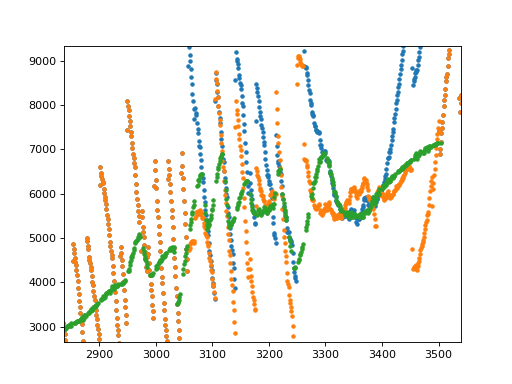

In [844]:
plt.figure()
plt.plot(datacube[:,7,6],'.')
plt.plot(Maskdata[:,7,6],'.')
#plt.plot(Corrected[:,7,7],'.')
plt.plot(d[:,7,6],'.')
#plt.plot(datacube[ind,7,7],'*')
#for t in thrusters:
#    plt.axvline(t,ls='--',color='red')
    
#for t in realt:
#    plt.axvline(t,ls='-.',color='k')

#for i in np.where(1081376 == Qual)[0]:
#    plt.axvline(i,ls='--',color='red')
#plt.xlim(400,600)

<IPython.core.display.Javascript object>


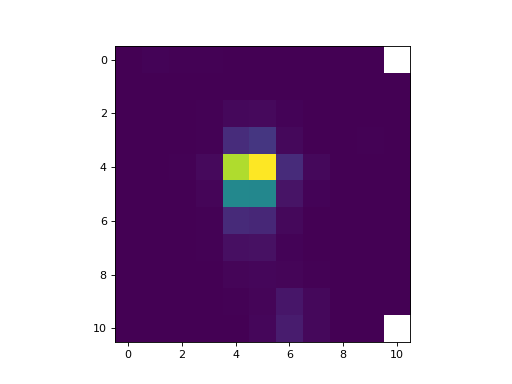

In [763]:
plt.figure()
plt.imshow(datacube[800])

In [25]:
Data = datacube.copy()
Mask = allMask
Thrusters = thrusters
Dist = np.copy(distdrif)


Corrected = np.zeros((Data.shape[0],Data.shape[1],Data.shape[2]))
Motion_flag = np.zeros(Data.shape[0])
fit = np.zeros(len(Data))
X = np.where(Mask == 1)[0]
Y = np.where(Mask == 1)[1]
for j in range(len(X)):
    temp = np.copy(Data[:,X[j],Y[j]])
    zz = np.arange(0,len(Data))
    AvSplineind = []
    for i in range(len(Thrusters)-1):
        beep = []
        beep = Dist[Thrusters[i]+1:Thrusters[i+1]-1]
        if (beep < 0.3).any():
            datrange = Data[Thrusters[i]+1:Thrusters[i+1]-1,X[j],Y[j]]
            # Need to make sure most stable frame isnt skewed by a cosmic ray or asteroid. 
            # make a standard deviation cut on all points in the thruster interval,
            # then reset all values which exceed by either the average of its neighbours, 
            # or neigbour value for frings cases.
            lim = np.nanmedian(datrange)+3*np.nanstd(datrange)
            ind = np.where(datrange > lim)[0]
            for index in ind:
                if (index < len(datrange) - 1) & (index > 0):
                    datrange[index] = np.nanmedian([datrange[index-1],datrange[index+1]])
                elif (index == 0):
                    datrange[index] = datrange[index+1]
                elif (index >= len(datrange)-1):
                    datrange[index] = datrange[index-1]


            val = Data[np.where(beep == np.nanmin(beep))[0][0]+Thrusters[i]+1,X[j],Y[j]]
            #if val < np.nanmedian(datrange) + 2*np.nanstd(datrange):
            AvSplineind.append(np.where(beep == np.nanmin(beep))[0][0]+Thrusters[i]+1)
        else:
            Motion_flag[Thrusters[i]+1:Thrusters[i+1]-1] = 1
    AvSplineind = np.array(AvSplineind)

    if len(AvSplineind) > 1:
        AvSplinepoints = np.copy(Data[AvSplineind,X[j],Y[j]])
        Splinef = interp1d(AvSplineind, AvSplinepoints, kind='linear', fill_value=np.nan, bounds_error = False)
        Spline = Splinef(zz)

        for i in range(len(Thrusters)-1):

            if abs(Thrusters[i]-Thrusters[i+1]) > 5:
                try:
                    Section = np.copy(Data[Thrusters[i]+2:Thrusters[i+1],X[j],Y[j]]) - Spline[Thrusters[i]+2:Thrusters[i+1]]
                    temp2 = np.copy(Section)
                    #temp2[Spline[Thrusters[i]+2:Thrusters[i+1]] == -1e10] = np.nan
                    x = np.arange(0,len(Section))
                    

                    ind = np.where(~np.isnan(temp2))[0]

                    if (len(x[ind]) > 3) & (len(x[ind])/len(x) > 0.6):
                        polyfit, resid, _, _, _  = np.polyfit(x[ind], Section[ind], 3, full = True)
                        p3 = np.poly1d(polyfit)
                        original_data = np.copy(Data[Thrusters[i]+2:Thrusters[i+1],X[j],Y[j]])
                        reduced_data = np.copy(Data[Thrusters[i]+2:Thrusters[i+1],X[j],Y[j]]) - p3(x) 

                        #chi = np.nansum((original_data-(p3(x)))**2/())
                        #chir = chi/(len(Flux)-2)
                        #pval = 1 - stats.chi2.cdf(chir,1)
                        #if pval > 0.6:

                        if abs(np.nanmedian(original_data) - np.nanmedian(reduced_data))/np.nanstd(original_data) < 2:
                            temp[x+Thrusters[i]+2] = np.copy(Data[Thrusters[i]+2:Thrusters[i+1],X[j],Y[j]]) - p3(x) 
                            temp[Thrusters[i]:Thrusters[i]+2] = np.nan
                    # This should kill all instances of uncorrected data due to drift systematically being > 0.3 pix
                    if (np.isnan(Spline[Thrusters[i]+2:Thrusters[i+1]])).all():
                        temp[x+Thrusters[i]+2] = np.nan
                except RuntimeError:
                    pass

    Corrected[:,X[j],Y[j]] = temp                    

In [610]:
np.isfinite(datacube[:,7,7]).shape

(4022,)

In [124]:
from scipy.interpolate import CubicSpline

<IPython.core.display.Javascript object>


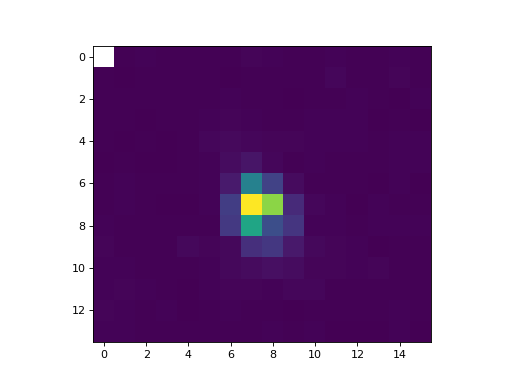

In [99]:
plt.figure()
plt.imshow(datacube[1000])

In [373]:
allflux = np.nansum(datacube,axis=0)
np.where(np.nanmax(allflux) == allflux)

(array([7]), array([8]))

In [530]:
nonan = datacube[np.isfinite(datacube[:,7,8]),7,8]
nonanthrust = thrusters[thrusters == np.where(~np.isfinite(datacube[:,7,8]))[0]]
coeffs = pywt.wavedec(nonan, 'db2',level=20)
eh = abs(coeffs[-1][:-1])# / nonan[::2]

peaks = find_peaks(eh,distance=4,prominence=np.mean(eh))[0]

In [531]:
peaks

array([  51,   81,  140,  152,  198,  222,  234,  245,  257,  275,  281,
        287,  299,  305,  317,  329,  340,  352,  364,  370,  376,  406,
        423,  435,  441,  453,  459,  471,  476,  482,  494,  500,  512,
        518,  524,  529,  541,  547,  559,  577,  588,  594,  606,  623,
        635,  647,  659,  670,  682,  694,  706,  712,  736,  754,  765,
        777,  795,  801,  819,  837,  849,  866,  896,  908,  932,  982,
       1071, 1089, 1095, 1101, 1113, 1119, 1125, 1131, 1137, 1143, 1149,
       1154, 1160, 1166, 1178, 1184, 1190, 1196, 1212, 1218, 1236, 1242,
       1247, 1253, 1265, 1271, 1277, 1283, 1289, 1295, 1301, 1319, 1325,
       1331, 1337, 1342, 1348, 1354, 1360, 1366, 1378, 1384, 1389, 1395,
       1401, 1407, 1413, 1419, 1425, 1431, 1437, 1443, 1449, 1461, 1467,
       1473, 1479, 1490, 1496, 1502, 1508, 1514, 1520, 1526, 1537, 1543,
       1549, 1561, 1567, 1573, 1585, 1591, 1597, 1603, 1614, 1620, 1638,
       1644, 1650, 1656, 1662, 1668, 1673, 1685, 16

<IPython.core.display.Javascript object>


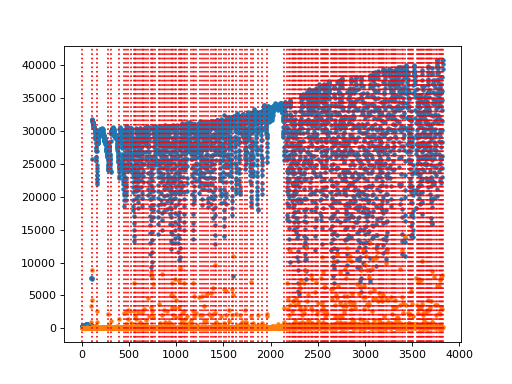

In [535]:
plt.figure()
plt.plot(nonan,'.')#/np.median(nonan))
plt.plot(x[:-1],eh,'.')
#for p in peaks:
#    plt.axvline(x[p],color='m',ls='--')
    
#plt.plot(x[1:-1],abs(np.diff(eh)))

#for v in np.where((q==1048576) | (q==524288))[0]:
#    plt.axvline(v,color='k',ls=':')

for r in realt:
    plt.axvline(r,color='r',ls=':')
#plt.xlim(650,710)

In [502]:
realt

array([   0,   51,   81,  103,  140,  152,  163,  198,  222,  234,  245,
        257,  275,  281,  287,  299,  304,  317,  329,  340,  352,  364,
        370,  376,  396,  406,  423,  435,  444,  453,  459,  468,  476,
        482,  491,  500,  515,  524,  529,  541,  547,  551,  559,  577,
        588,  594,  598,  606,  610,  623,  634,  646,  658,  670,  681,
        694,  705,  712,  729,  736,  741,  754,  765,  776,  795,  801,
        812,  819,  824,  837,  849,  866,  870,  882,  896,  906,  918,
        932,  953,  965,  982,  989, 1001, 1025, 1048, 1059, 1071, 1083,
       1089, 1095, 1101, 1113, 1118, 1125, 1131, 1137, 1143, 1149, 1153,
       1160, 1166, 1177, 1184, 1189, 1196, 1213, 1218, 1236, 1242, 1247,
       1253, 1265, 1271, 1277, 1283, 1289, 1295, 1301, 1319, 1325, 1331,
       1337, 1341, 1348, 1354, 1360, 1365, 1378, 1384, 1389, 1395, 1401,
       1407, 1413, 1419, 1424, 1431, 1437, 1443, 1448, 1461, 1467, 1472,
       1479, 1490, 1496, 1502, 1508, 1514, 1520, 15

In [16]:
Get_all_resets(datacube,Qual)

array([   0,  100,  105,  142,  165,  189,  224,  285,  309,  381,  405,
        453,  477,  478,  501,  525,  561,  573,  585,  603,  609,  621,
        645,  669,  670,  693,  717,  741,  753,  765,  789,  825,  837,
        861,  885,  897,  921,  933,  957,  969,  981, 1005, 1017, 1041,
       1053, 1065, 1077, 1101, 1113, 1137, 1149, 1173, 1197, 1209, 1233,
       1245, 1269, 1293, 1317, 1341, 1365, 1389, 1413, 1437, 1449, 1473,
       1497, 1533, 1556, 1581, 1617, 1629, 1665, 1701, 1725, 1761, 1773,
       1821, 1845, 1893, 1941, 2088, 2133, 2181, 2277, 2313, 2349, 2361,
       2373, 2374, 2397, 2409, 2421, 2433, 2445, 2457, 2469, 2470, 2481,
       2493, 2505, 2529, 2541, 2553, 2565, 2577, 2601, 2613, 2625, 2649,
       2661, 2673, 2685, 2709, 2721, 2733, 2745, 2757, 2769, 2781, 2793,
       2817, 2829, 2841, 2853, 2865, 2877, 2889, 2901, 2913, 2925, 2937,
       2949, 2961, 2973, 2985, 2997, 3009, 3020, 3033, 3045, 3057, 3069,
       3081, 3105, 3117, 3129, 3141, 3142, 3165, 31

In [19]:
def Get_all_resets(Data, Quality):
    allflux = np.nansum(Data,axis=0)
    ind1, ind2 = np.where(np.nanmax(allflux) == allflux)

    nonan = datacube[np.isfinite(Data[:,ind1[0],ind2[0]]),ind1[0],ind2[0]]
    nonaninds = np.where(np.isfinite(Data[:,ind1[0],ind2[0]]))[0]
    coeffs = wavedec(nonan, 'db2',level=20)
    eh = abs(coeffs[-1][:-1])# / nonan[::2]
    eh_x = np.arange(0,len(coeffs[-1])*2,2)
    peaks = find_peaks(eh,distance=4,prominence=np.mean(eh))[0]

    peaks = nonaninds[eh_x[peaks]]

    realt = np.where((Quality==1048576) | (Quality==524288) | (Quality==1081376))[0]
    for p in peaks:
        if ~np.isclose(p, realt, atol=3).any():
            realt = np.append(realt, p)

    realt = np.sort(realt)
    
    return realt

def Regress_fit(Data):
    ind = np.where(np.isfinite(Data))[0]
    x = np.arange(0,len(Data))
    x = x[ind]
    y = Data[ind]
    if len(y) >= 3:
        x = x[:, np.newaxis]
        y = y[:, np.newaxis]

        polynomial_features= PolynomialFeatures(degree=6)
        x_poly = polynomial_features.fit_transform(x)

        model = LinearRegression()
        model.fit(x_poly, y)
        y_poly_pred = model.predict(x_poly)

        rmse = np.sqrt(mean_squared_error(y,y_poly_pred))
        r2 = r2_score(y,y_poly_pred)

        sort_axis = operator.itemgetter(0)
        sorted_zip = sorted(zip(x,y_poly_pred), key=sort_axis)
        x, y_poly_pred = zip(*sorted_zip)

        mod = np.zeros_like(y)
        for i in range(len(mod)):
            mod[i] = y_poly_pred[i][0]
    else:
        mod = np.zeros_like(y)
        mod[:] = np.nan
    fit = Data.copy()

    fit[ind] = np.squeeze(mod)

    return fit

def Correct_motion(Data, Distance, Thrust):
    data = Data.copy()
    data[Thrust] = np.nan
    data[Thrust[:-1]+1] = np.nan
    data[Thrust[:-1]+2] = np.nan
    data[Thrust[1:]-1] = np.nan
    X, Y = np.where(np.nansum(data,axis=0) != 0)
    
    fitting = data.copy()
    spline = data.copy()
    x = np.arange(data.shape[0])
    for j in range(len(X)):
        trend = []
        for i in range(len(Thrust)-1):
            section = data[Thrust[i]:Thrust[i+1]-1,X[j],Y[j]].copy()
            if len(section) > 3:
                nanmask = sigma_clip(section,masked=True).mask
                section[nanmask] = np.nan


                fitting[Thrust[i]:Thrust[i+1]-1,X[j],Y[j]] = Regress_fit(section)

                d = Distance[Thrust[i]:Thrust[i+1]-1]
                ind = np.where(np.isfinite(section))[0]
                
                if (d[ind] <=0.1).any():
                    inds = np.where(d[ind] <=0.1)[0]
                    for k in inds:
                        trend += [[ind[k]+Thrust[i],section[ind[k]]]]
                    
                elif (d[ind] <= 0.3).any():
                    mind = np.nanmin(d[ind])
                    ind2 = np.where(d[ind] == mind)[0][0]
                    trend += [[ind[ind2]+Thrust[i],section[ind[ind2]]]]
                    

        trend = np.array(trend)
        trend = trend[trend[:,0].argsort()]
        #return trend
        #spl = PchipInterpolator(trend[:,0], trend[:,1],extrapolate=False)
        spl = interp1d(trend[:,0], trend[:,1], kind = 'linear',bounds_error=False)
        x = np.arange(data.shape[0])
        spl = spl(x)
        
        spline[:,X[j],Y[j]] = spl
    data = data - (fitting ) + spline
    
    return data, fitting, spline

In [79]:
s = Correct_motion(datacube,distdrif,realt)

In [97]:
realt = Get_all_resets(datacube,Qual)
d, f, s = Correct_motion(datacube,distdrif,realt)

<IPython.core.display.Javascript object>


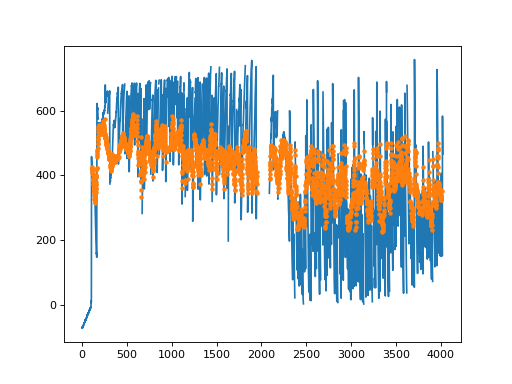

In [101]:
plt.figure()
plt.plot(datacube[:,7,7])
plt.plot(d[:,7,7],'.')
#plt.plot(f[:,7,7])
#plt.plot(s[:,7,7])

#for r in realt:
#    plt.axvline(r,ls='--',c='k')

In [27]:
sigma_clip(s,masked=True)

masked_array(data=[--, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, -9.397856712341309,
                   -9.795862197875977, -9.00887393951416,
                   -5.657029151916504, -7.836023330688477,
                   -7.143130302429199, -1.6104238033294678,
                   -4.047151565551758, -3.041748046875,
                   -3.4139513969421387, 1.4309176206588745,
                   -0.2159785032272339, 2.3806653022766113,
                   2.8667914867401123, 1.085789442062378,
                   4.77431583404541, 3.153564453125, 5.8438615798950195,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, -8.836929321289062, -7.719630241394043,
                   -8.755961418151855, -7.543736934661865,
                   -4.015644550323486, -4.311979293823242,
                   -0.7576584815979004,

In [922]:
from astropy.stats import sigma_clip

In [44]:
basic(np.array([0,0,np.nan,0,100,0,0,0,0,0,0,0,0,0,0,0,0,0]))

array([False, False,  True, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False])

In [892]:
X, Y = np.where(np.nansum(datacube,axis=0) != 0)
np.where((X==2) & (Y==12))

(array([43]),)

In [862]:
from scipy.interpolate import splrep

In [908]:
Thrust = realt.copy()
data = datacube.copy()
Distance = distdrif.copy()

data[Thrust] = np.nan
data[Thrust[:-1]+1] = np.nan
data[Thrust[1:]-1] = np.nan
X, Y = np.where(np.nansum(data,axis=0) > 0)

fitting = data.copy()
spline = data.copy()

j = 43
trend = []
for i in range(len(Thrust)-1):
    section = data[Thrust[i]:Thrust[i+1]-1,X[j],Y[j]].copy()

    fitting[Thrust[i]:Thrust[i+1]-1,X[j],Y[j]] = Regress_fit(section)

    d = Distance[Thrust[i]:Thrust[i+1]-1]
    ind = np.where(np.isfinite(section))[0]

    if (d[ind] <= 0.2).any():
        mind = np.nanmin(d[ind])
        ind2 = np.where(d[ind] == mind)[0][0]
        trend += [[ind[ind2]+Thrust[i],section[ind[ind2]]]]

trend = np.array(trend)
spl = PchipInterpolator(trend[:,0], trend[:,1],extrapolate=False)
#spl = interp1d(trend[:,0], trend[:,1], kind = 'linear',bounds_error=False)
x = np.arange(data.shape[0])
spl = spl(x)

spline = spl

<IPython.core.display.Javascript object>


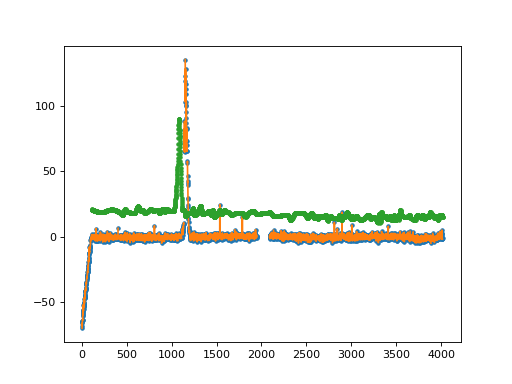

In [909]:
plt.figure()
plt.plot(data[:,2,12],'.')
plt.plot(fits[:,2,12],'-')
plt.plot(spline,'.')

#for i in range(len(trend)):
#    plt.plot(trend[i,0],trend[i,1],'k.')
